# Assignment 02 - Construct the Neural Network

This will be the actual construction, training, testing, validation of the model. We will provide brief justification for each step because it will make writing the actual report easier.
______

### TODO:

    1. Make sure import statements work (DONE!)
    2. Return a LOOCV Train Test split.
    3. Preprocessing function should output a 2-D tensor. We will construct a 3-D tensor for all values. (NAH)
    4. Train and Construct the model. (CONSTRUCTED)
    5. Evaluation metrics for base model. (WILL BE INCLUDED)
    6. Compare with distinctiveness pruning.
    7. If all of this is done on time then add additional EA feature and hyperparameter selection (GREEDY)

______

In [1]:
###IMPORTS###
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import random
from random import shuffle

import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split #pre all but one training
from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.metrics import confusion_matrix #analysis
import torch.nn.utils.prune as prune
import torch.nn.functional as F

#Visualization Imports
import matplotlib.pyplot as plt

#Machine Learning Imports
import torch
import torch.nn as nn
import torch.nn.functional as F #Neural Network used in Comp4660 at ANU
import torch
from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
### - GLOBALS - ###

Y = pd.read_csv('subjective-belief_v2/TimeseriesObserver/subjective_belief_observers_ts_labels.csv')
cats = ['PUPIL', 'EDA', 'BVP', 'TEMP', 'tags']
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive', 'tab:orange']
num_l_features = 3

In [3]:
#### - SEARCH FOR FUNCTIONS BASED ON PID_VID - ###
def fetch_TS(ID, index, category):
    #Define base pathway
    bp = 'subjective-belief_v2/TimeseriesObserver/raw_observer_physio_data/'
    #fetch outward file
    f1=ID[0:3] + '/'
    #We know that pairs of video data were gathered. So we must take this one and the ID afterwards
    idp1 = Y['pid_vid'][index+1]
    pair = ID[4:] + idp1[4:] + '/'
    return pd.read_csv(bp + f1 + f1[0:3] + '_' + pair + category + '.csv')

In [4]:
### - RETURN TAGS FROM TAGS.CSV FOR THE DATA - ###
def fetch_tags(index):
    fv = index.columns[0]
    times_array = np.insert(index.to_numpy(), 0, float(fv))
    return times_array

In [5]:
### - FETCH DATA FROM FILES BY INDEX - ###

#PLEASE NOTE INDEXES SHOULD INCREASE BY 2! This will also be included in the assignment. As it is necessary.
#PreProcessing of features should be conducted before training(I.E. Splitting into local features)
def fetch_data(index):
    id1 = Y['pid_vid'][index]
    Left_Pupil1 = 0 #DEFINE ALL VARIABLES THAT WILL BE RETURNED
    Right_Pupil1 = 0
    BVP1 = 0
    EDA = fetch_TS(Y['pid_vid'][index], index, cats[1])
    Temp = fetch_TS(Y['pid_vid'][index], index, cats[3]) #For now we will take the average temperature across the two videos
    
    #NORMALIZE EDA AND TEMP THEN FIND AVERAGE
    sc = MinMaxScaler()
    EDA = np.mean(sc.fit_transform(EDA.to_numpy().reshape(-1,1)))
    Temp = np.mean(sc.fit_transform(Temp.to_numpy().reshape(-1,1)))
    
    id2 = Y['pid_vid'][index+1]
    Left_Pupil2 = 0 #DEFINE ALL VARIABLES THAT WILL BE RETURNED
    Right_Pupil2 = 0
    BVP2 = 0
    #THESE VALUES WILL BE DATAFRAMES. USED IN THIS DOCUMENT FOR GRAPHING AND ANALYSIS
    
    #No matter what we will use the later start time to align the data.
    tags = fetch_tags(fetch_TS(Y['pid_vid'][index], index, cats[4]))
    for x in range(0,len(cats)):
        if cats[x] != 'tags':
            indexed_point = fetch_TS(Y['pid_vid'][index], index, cats[x])
            indices = indexed_point.index.tolist()
            ST = float(indexed_point.columns[0]) #Start time for BVP, EDA, TEMP
            
            si1 = 0
            si2 = int((tags[1] - tags[0])) * 60 #start vid 2-start_time / sr
            
            si1b = 0
            si2b = 0
            if cats[x] == 'PUPIL':
                #Append no preprocessed data size
                v1 = 0
                v2 = 0
                indices1 = []
                indices2 = []
                if float(tags[0]) > ST:
                    v1 = int((float(tags[1]) - float(tags[0]))) * 60
                    v2 = int((float(tags[3]) - float(tags[2]))) * 60
                else:
                    v1 = int((float(tags[1]) - ST)) * 60
                    v2 = int((float(tags[3]) - float(tags[2]))) * 60
                    si1 = int((ST - tags[0]) * 60)
                #FOR THESE NEXT TWO CASES WE FIND THE START INDEX
                if v1 > v2: #If video size is different this helps us
                    #in this case only use v1 sample #'s'
                    indices1 = [int(si1),int((si1+v2))]
                    indices2 = [int(si2),int((si2+v2))]
                else: 
                    #in this case only use v2 sample #'s'
                    indices1 = [int(si1),int((si1+v1))]
                    indices2 = [int(si2),int((si2+v1))]
                indices1 = range(indices1[0], indices1[1])
                indices2 = range(indices2[0], indices2[1])
                #APPEND TO EACH RETURN LIST
                Left_Pupil1 = indexed_point.iloc[:,0][list(indices1)]
                Right_Pupil1 = indexed_point.iloc[:,0][list(indices1)]
                Left_Pupil2 = indexed_point.iloc[:,0][list(indices2)]
                Right_Pupil2 = indexed_point.iloc[:,0][list(indices2)]
            elif cats[x] == 'BVP':
                sr = indexed_point[indexed_point.columns[0]].iloc[0] #Sample rate for measurement
                #Since we have sample rate. Should be end-start/samplerate to get all of the indices for that video.
                v1 = 0
                v2 = 0
                indices1 = []
                indices2 = []
                if float(tags[0]) > ST:
                    si1b = int((float(tags[0]) - ST)) #Set to the index of the start of PD being measures
                    v1 = (int((float(tags[3]) - float(tags[0]))) * sr) / 2
                    v2 = v1
                else:
                    si1b = int(ST - (float(tags[0]))) * sr
                    v1 = int((float(tags[3]) - float(tags[0]))) 
                    v2 = v1
                #FOR THESE NEXT TWO CASES WE FIND THE START INDEX
                si2b = (si1b+(v1)) + ((float(tags[2])-float(tags[1])) * sr)
                l = v1 * (sr/60)
                indices1 = [int(si1b),int((si1b+l))]
                indices2 = [int(si2b),int((si2b+l))]
                indices1 = range(indices1[0], indices1[1])
                indices2 = range(indices2[0], indices2[1])
                
                #Amend indices1 and 2 so that we can have the same number of sample points
                indices1 = list(indices1)
                indices2 = list(indices2)
                while len(indices1) - Left_Pupil1.shape[0] > 2:
                    diff = len(indices1) - Left_Pupil1.shape[0]
                    every_X = Left_Pupil1.shape[0] / diff

                    del indices1[int(every_X+1)::int(every_X+2)]
                    
                    del indices2[int(every_X+1)::int(every_X+2)]
                
                if len(indices1) - Left_Pupil1.shape[0] >= 1:
                    diff = len(indices1) - Left_Pupil1.shape[0]
                    for i in range(0,diff):
                        indices1.pop()
                        indices2.pop()
                
                #APPEND TO EACH RETURN LIST
                BVP1 = indexed_point.iloc[:,0][indices1]
                BVP2 = indexed_point.iloc[:,0][indices2]
    ### - RETURN TWO LISTS 1 FOR EACH DATA POINT. IDENTIFIED BY ID FOR EACH - ###
    return [[id1, Left_Pupil1, Right_Pupil1, BVP1, EDA, Temp],
                      [id2, Left_Pupil2, Right_Pupil2, BVP2, EDA, Temp]]

In [6]:
#Just for testing, remove cell once we know preprocess works
Example = fetch_data(0)
print(Example[0][4], Example[0][5]) #NORMALIZED TEMP AND EDA STATS
print(Example[0][1])

0.06022882449725776 0.9916431448115781
0        0.0000
1       20.7494
2       20.6755
3       19.2404
4       19.6714
         ...   
1915    23.2295
1916    23.3596
1917    23.4777
1918    23.3632
1919    23.2711
Name: 20.9644, Length: 1920, dtype: float64


In [7]:
### - DEFINE A PREPROCESSING FUNCTION FOR THE DATA - ###
#Note: The input type for the preprocess function will be a list of [id, LP, RP, BVP, EDA (avg), Temp(avg)]
#      graphs is simply either 'TRUE' or 'FALSE'
#      num_l_features is the number of local features, In how we split the data. Default would trying to analyze the
#.     data in 2 second intervals so 16 local features (PD AND BVP).
def ts_preprocessLSTM(data, graphs, num_l_features):
    #Split and Fetch Data (ease of coding)
    LP = np.array(data[1])
    RP = np.array(data[2])
    BVP = np.array(data[3])
    EDA = data[4]
    T = data[5]
    
    #NORMALIZE ALL (EDA AND TEMP ALREADY NORMALIZED)
    sc = MinMaxScaler()
    LP = sc.fit_transform(LP.reshape(-1,1))
    RP = sc.fit_transform(RP.reshape(-1,1))
    BVP = sc.fit_transform(BVP.reshape(-1,1))
    
    #Extract Local Features: This will be used for the Network. We make a list Where Temperature and EDA are just
    #                        cloned to match lengths of LP RP and BVP. CHECK THIS
    
    setLP = []    
    setRP = [] 
    setBVP = []
    for x in LP:
        setLP.append(x[0])
    for x in RP:
        setRP.append(x[0])
    for x in BVP:
        setBVP.append(x[0])
        
    LP = setLP
    RP = setRP
    BVP = setBVP
    
    #Return statement
    return [data[0], LP, RP, BVP, EDA, T]
    

In [8]:
### - EXAMPLE OF PREPROCESSED DATA - ###
ExamplePP = ts_preprocessLSTM(Example[0], 'TRUE', num_l_features)

In [9]:
#global variable for pruning. This can be set to true or false to notice improvements
prune = False

2
False
LSTMTS(
  (lstm): LSTM(2, 50)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


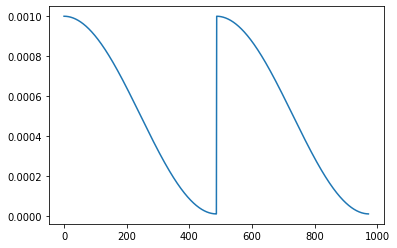

In [10]:
### - CONSTRUCT THE NETWORK - ###
## - AVAILABLE GPU TRAINING - ##
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
#Calculate number of features total 3*lp/rp/bvp + EDA + Temp
num_f = 2
print(num_f)

is_cuda = torch.cuda.is_available()
print(is_cuda)

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
#Cyclic LR Scheduler
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

#construct network
class LSTMTS(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, 1)

        self.fc2 = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.randn(1,1,self.hidden_layer_size),
                            torch.randn(1,1,self.hidden_layer_size))

    def forward(self, x, hprev, cprev):
        lstm_out, hc = self.lstm(x.view(len(x) ,1, -1), (hprev, cprev))
        out = self.fc2(lstm_out.view(len(x), -1))
        out = F.sigmoid(out)
        #We find unequal lengths in the data so you have to pick the correct final prediction value.
        return out, hc

#define hyperparameters
input_size = 2
output_size = 1
hidden_dim = 100

if not prune:
    hidden_dim = 50

model = LSTMTS(input_size, hidden_dim, output_size)

print(model)

lr=0.001
loss_func = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
sched = CyclicLR(optimiser, cosine(t_max=(304-(304/3)) * 2, eta_min=lr/100))

decayRate = lr/30 #30 is num_epochs
lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma=decayRate)

scheduled = cosine(t_max=(304-(304/5)) * 2, eta_min=lr/100)
learning_rates = [scheduled(t, .001) for t in range(int((304-(304/5))) * 4)]
plt.plot(learning_rates)

In [11]:
### - CONSTRUCT 3-D Tensor of all data - ###

def construct_df(pid_vid):
    ### - Should output a df of the test subject - ###
    #Start by finding the index of the test subject in Y
    i = Y[Y['pid_vid']==pid_vid].index.values[0]
    y = Y[Y.columns[1]][i]
    i_acc = i
    if i % 2 == 1:
        i_acc = i-1
    retrieve = i_acc-i
    sub = fetch_data(i_acc)
    column_names = ['lp', 'rp']
    #create the list of lists
    testsub = ts_preprocessLSTM(sub[retrieve], 'FALSE', num_l_features)
    #convert to list of lists w/ correct local features
    data = [testsub[1], testsub[2]]
    templ = []
    edal = []
    df = pd.DataFrame(data)
    df = df.transpose()
    df.columns = column_names
    return df, y

#EXAMPLE PREDICTION

In [12]:
#Define loss smoothing function
smooth_loss = -np.log(1.0/120)

In [13]:
### Return the dataset as a list of variables in an index ###
Xs = []
ys = []
for i in range(304):
    index_id = Y['pid_vid'][i]
    X, y = construct_df(index_id)
    X = X.dropna()
    Xs.append(X)
    ys.append(y)
Xs = np.array(Xs)
ys = np.array(ys)
print(len(Xs), len(ys))

304 304


In [14]:
#Helper functions for below cell:
#define a custom pruning function
#calculate angle
def calc_angle(x,y):
    incos1 = (np.dot(x,y))
    incos2 = (np.linalg.norm(x) * np.linalg.norm(y))
    bet = incos1/incos2
    return(math.degrees(math.acos(bet)))
def merge_neurons(i, j, module, output_a):
    #index of neuron to keep: i; index of neuron to merge: j; module should be the pattern set (net.fc1)
    #Retrieve Weights:
    with torch.no_grad():
        weights = module.state_dict()['weight_hh_l0'].T
        torch.transpose(module.state_dict()['weight_hh_l0'], 0, 1)[i] = (module.state_dict()['weight_hh_l0'].T[j] + module.state_dict()['weight_hh_l0'].T[j])/2 #add the two
        biases = module.state_dict()['bias_ih_l0']
        module.state_dict()['weight_hh_l0'].T[i] = module.state_dict()['weight_hh_l0'].T[i] + module.state_dict()['weight_hh_l0'].T[j] #add the two
        module.state_dict()['weight_hh_l0'].T[j] = module.state_dict()['weight_hh_l0'].T[j] * 0 #Remove the j weight
        module.state_dict()['bias_ih_l0'][j] = module.state_dict()['bias_ih_l0'][j] * 0 #Remove J bias
        #Remove output activation for removed neuron
        output_a.weight.data[0][j] = 0 
    return True
def remove_neurons(i, j, module, output_a):
    #index of neurons to remove: i,j; module should be the pattern set (net.fc1)
    with torch.no_grad():
        module.state_dict()['weight_hh_l0'].T[i] = torch.tensor(0.0, requires_grad=True)
        module.state_dict()['bias_ih_l0'][i] = torch.tensor(0.0, requires_grad=True)
        module.state_dict()['weight_hh_l0'].T[j] = torch.tensor(0.0, requires_grad=True)
        module.state_dict()['bias_ih_l0'][j] = torch.tensor(0.0, requires_grad=True)
        output_a.weight.data[0][i] = torch.tensor(0.0, requires_grad=True)
        output_a.weight.data[0][j] = torch.tensor(0.0, requires_grad=True)
    return True

def reset_zeros(pruned_m, pruned_d, module, output_a):
    #Resets all the neurons that have been removed. 
    #retrieve indices to delete
    delete = []
    for x in pruned_d:
        delete.append(x[0])
        delete.append(x[1])
    for x in pruned_m:
        delete.append(x[1])
    with torch.no_grad():
        #Delete nodes
        module.state_dict()['weight_hh_l0'].T[delete] = torch.tensor(0.0, requires_grad=True)
        module.state_dict()['bias_ih_l0'][delete] = torch.tensor(0.0, requires_grad=True)
        output_a.weight.data[0][delete] = torch.tensor(0.0, requires_grad=True)
    return True

In [15]:
#Pruning Cells:
#Investigative stage.
#Retrieve weights and biases of Input to hidden and hidden to input connections
def prune_net():
    module1 = model.lstm
    module2 = model.fc2

    m1params = list(module1.state_dict()['weight_hh_l0'].T)
    print(module1.state_dict()['weight_hh_l0'].T.shape)
    m2params = list(module2.weight)

    #These are just to observe. Was to help me visual and understand the sample space
    #print(m1params)
    #print(m1params[0].size(0), len(m1params))
    #print(m2params)
    #print(m2params[0].size(0), len(m2params))

    #so we know what we are looking at model1params weight vectors
    tmerge = [] #nodes to remove. 
    trem = []
    inspected = []
    largest_angle = [0,0,0,0]
    smallest_angle = [0,0,180,1]
    for i, x in enumerate(m1params):
        #X is a tensor we should retrieve the actual vector
        vector_x = x.tolist() #convert so we can perform matrix math
        #retrieve list of comparison vectors. everything in m1params except vector x
        for j, y in enumerate(m1params):
            cur = (i,j)
            if not i == j and cur not in inspected:
                #retrieve Y vector:
                vector_y = y.tolist()
                angle = calc_angle(vector_x, vector_y)
                inspected.append((i,j)) #make sure that the same pair of vectors is not looked at again.
                inspected.append((j,i))
                if angle > largest_angle[2]:
                    largest_angle = [i,j,angle,0]
                if angle < smallest_angle[2]:
                    smallest_angle = [i,j,angle,1]
    print(largest_angle, smallest_angle)
    #decide what to prune
    difflarge = largest_angle[2] - 125
    diffsmall = 55-smallest_angle[2]
    if difflarge > diffsmall and largest_angle[2]>=125:
        #delete the two counteractive nodes
        #print("Nodes to remove: " + str(largest_angle[0]) + ", " + str(largest_angle[1]) + ", Angle: " + str(largest_angle[2]) + " degrees")
        if remove_neurons(largest_angle[0], largest_angle[1], model.lstm, model.fc2):
            return largest_angle
    elif smallest_angle[2]<=55:
        #Merge similar nodes
        #print("Node to keep: " + str(smallest_angle[0]) + ", Node to merge: " 
        #      + str(smallest_angle[1]) + ", Angle: " + str(smallest_angle[2]) + " degrees")
        if merge_neurons(smallest_angle[0], smallest_angle[1], model.lstm, model.fc2):
            return smallest_angle
    else:
        return False

In [ ]:
### - TRAIN THE MODEL LOOCV TRAINING - ###
#P29-36 will be ignored#

all_losses_e = []
all_acc_e = []

all_tloss_e = []
all_tacc_e = []

#Train With Network Pruning By Weights
# store all losses for visualisation
pruned_neurons_D = [] #allows us to update and set = to 0 every training cycle.
pruned_neurons_M = [] #allows us to update and set = to 0 every training cycle.

num_epochs = 25

folds = 3

#'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36' are untrainable.

d = list(range(304))
shuffle(d) #Data is shuffled

d = np.array_split(d, folds+1)

val = d[folds] #These are indices

hprev = torch.zeros(1,1,hidden_dim)
cprev = torch.zeros(1,1,hidden_dim)

for epoch in range(num_epochs):
    
    # Perform forward pass: compute predicted y by passing x to the model.
    # Here we pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    #Training Measurements
    losses = [] #All losses across all training cycles. To be averaged out for final loss per epoch
    acc = []
    
    losses_t = [] #All losses across testing cycle. To be averaged out for final loss per epoch
    correct_t = 0
    total_t = 0
    
    acc_t = []
    
    correct_train = 0
    
    #3-Fold CV This is to keep everything pretty small and raise the test set size
    for i in range(folds): #304 is when pupillary data stops
        output = [] #output from sigmoid values
        output_t = []
        
        curr_test_x = Xs[d[i]]
        curr_test_y = ys[d[i]]
        
        train_i = np.array(d[:i] + d[i+1:])
        train_i = np.append(train_i[0], train_i[1])
        
        curr_train_x = Xs[train_i]
        curr_train_y = ys[train_i]
        #curr_train_x = Variable(torch.from_numpy(np.array(curr_train_x).astype(np.double)))
        
        for k, x in enumerate(curr_train_x):
            x = Variable(torch.from_numpy(np.array(x).astype(np.float)))
            
            y = Variable(torch.from_numpy(np.array(curr_train_y[k]).astype(np.int)))
            y = y.unsqueeze(-1)
            y = y.float()
            
            #Model train inputs and set
            y_pred_train, hcprev = model(x.float(), hprev, cprev)
            hprev = hcprev[0].detach()
            cprev = hcprev[1].detach()
            
            loss = loss_func(y_pred_train[-1], y)
            losses.append(loss.item())
            
            y_pred_train = round(y_pred_train[-1].item())
            
            output.append(y_pred_train)
            
            sched.step()

            #clear gradients
            model.zero_grad(set_to_none=True)

            # Perform backward pass: compute gradients of the loss with respect to
            # all the learnable parameters of the model.
            loss.backward()

            # Calling the step function on an Optimiser makes an update to its
            # parameters
            optimiser.step()
                
        #Retrieve evaluation metrics
        corr = 0
        for j, x in enumerate(output):
            if x == curr_train_y[j]:
                corr = corr + 1
        assert len(curr_train_x) == len(output)
        
        ac = corr/(len(output))
        
        assert len(curr_train_x) == len(output)
        
        acc.append(ac)
        
        ac = 0
        
        correct_t = 0
        
        for l, x in enumerate(curr_test_x):
            x = Variable(torch.from_numpy(np.array(x).astype(np.float)))
            pred_t, hc = model(x.float(), hprev, cprev)
            y = Variable(torch.from_numpy(np.array(curr_train_y[l]).astype(np.int)))
            y = y.unsqueeze(-1)
            y = y.float()
            #test loss
            t_loss = loss_func(pred_t[-1], y)
            losses_t.append(t_loss.item())
            output_t.append(pred_t[-1].item())
            
        for j, x in enumerate(output_t):
            if round(x) == curr_test_y[j]:
                correct_t = correct_t + 1
        
        ac_t = correct_t/(len(output_t))
        acc_t.append(ac_t)
        ac_t = 0
        
    #Reset all values that are supposed to be deleted to 0
    if prune:
        ds = '.' * (epoch+1)
        print('pruning' + ds)
        reset_zeros(pruned_neurons_D, pruned_neurons_M, model.lstm, model.fc2)

    if prune:
        node = prune_net()
        if not node == False:
            flag = 0
            for x in pruned_neurons_D:
                if x[0] == node[0] and x[1] == node[1]:
                    flag = 1
            for x in pruned_neurons_M:
                if x[0] == node[0] and x[1] == node[1]:
                    flag = 1
            if flag == 0:
                if node[3] == 0:
                    pruned_neurons_D.append(node)
                else:
                    pruned_neurons_M.append(node)
    ac = np.mean(acc)
    ac_t = np.mean(acc_t)
    
    all_tloss_e.append(np.mean(losses_t))
    all_tacc_e.append(ac_t)
        
    if epoch % 1 == 0:
        # convert three-column predicted Y values to one column for 

        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
                % (epoch + 1, num_epochs, loss.item(), ac*100))
        print('Testing Loss: %.4f  TestingAccuracy: %.2f %%'
                % (t_loss.item(), ac_t*100))
        if prune:
            print(pruned_neurons_D, pruned_neurons_M)
     
    all_losses_e.append(np.mean(losses))
    
    losses = []
    
    acc = []
    
    acc_t = []
    
    losses_t = []   
        

Epoch [1/25] Loss: 0.8190  Accuracy: 53.51 %
Testing Loss: 0.8222  TestingAccuracy: 53.95 %
Epoch [2/25] Loss: 0.8699  Accuracy: 53.73 %
Testing Loss: 0.8703  TestingAccuracy: 53.95 %
Epoch [3/25] Loss: 0.8638  Accuracy: 55.26 %
Testing Loss: 0.8547  TestingAccuracy: 53.95 %
Epoch [4/25] Loss: 0.8132  Accuracy: 55.92 %
Testing Loss: 0.7995  TestingAccuracy: 55.70 %
Epoch [5/25] Loss: 0.8049  Accuracy: 57.89 %
Testing Loss: 0.7875  TestingAccuracy: 55.70 %
Epoch [6/25] Loss: 0.6822  Accuracy: 57.68 %
Testing Loss: 0.6583  TestingAccuracy: 56.58 %
Epoch [7/25] Loss: 0.6553  Accuracy: 57.24 %
Testing Loss: 0.6314  TestingAccuracy: 57.02 %
Epoch [8/25] Loss: 0.6501  Accuracy: 56.80 %
Testing Loss: 0.6263  TestingAccuracy: 57.02 %
Epoch [9/25] Loss: 0.9478  Accuracy: 57.46 %
Testing Loss: 0.9444  TestingAccuracy: 55.70 %
Epoch [10/25] Loss: 1.0080  Accuracy: 56.14 %
Testing Loss: 0.9992  TestingAccuracy: 55.26 %
Epoch [11/25] Loss: 0.9194  Accuracy: 58.99 %
Testing Loss: 0.9000  TestingAccu

In [ ]:
#Graph of loss over time(Num Epochs)
print((num_epochs), len(all_losses_e))
print(all_losses_e)
plt.plot(range(0,(num_epochs)), all_losses_e, alpha=0.7, color='tab:red')
plt.xlabel('validations')
plt.ylabel('BCE Loss')
plt.title('Graph of Training Loss Over # Epochs')
plt.show()

print((num_epochs), len(all_losses_e))
print(all_tloss_e)
plt.plot(range(0,(num_epochs)), all_tloss_e, alpha=0.7, color='tab:blue')
plt.xlabel('validations')
plt.ylabel('BCE Loss')
plt.title('Graph of Testing loss Over # Epochs')
plt.show()

print((num_epochs), len(all_losses_e))
print(all_tacc_e)
plt.plot(range(0,(num_epochs)), all_tacc_e, alpha=0.7, color='tab:green')
plt.xlabel('validations')
plt.ylabel('BCE Loss')
plt.title('Graph of Testing Accuracy Over # Epochs')
plt.show()

In [ ]:
#Convusion Matrices and displays for Training and Testing Set
import seaborn as sn

output_t = np.round(output_t) #This is because raw test numbers were appended to output_t instead of the rounded

confusion_train = confusion_matrix(curr_train_y, output)

confusion_test = confusion_matrix(curr_test_y, output_t)

#Display confusion matrices, for report
confusion_tr = pd.DataFrame(confusion_train, index = [i for i in ['Actual +', 'Actual -']],
                  columns = [i for i in ['Pred +', 'Pred -']])

confusion_te = pd.DataFrame(confusion_test, index = [i for i in ['Actual +', 'Actual -']],
                  columns = [i for i in ['Pred +', 'Pred -']])

#Training Plot
fig, ax = plt.subplots()
hm = sn.heatmap(confusion_tr, annot=True, fmt="d", cmap='BuPu')
hm.set_xticklabels(labels=hm.get_xticklabels(), va='center')
hm.set_yticklabels(labels=hm.get_yticklabels(), va='center')
ax.set_ylim([0,2])
plt.title('Training Set Confusion Matrix', pad=30)
plt.show()

#Testing Plot
fig, ax = plt.subplots()
hm = sn.heatmap(confusion_te, annot=True, fmt="d", cmap="OrRd")
hm.set_xticklabels(labels=hm.get_xticklabels(), va='center')
hm.set_yticklabels(labels=hm.get_yticklabels(), va='center')
ax.set_ylim([0,2])
plt.title('Testing Set Confusion Matrix', pad=30)
plt.show()

In [ ]:
#Validation Set Handling:
curr_val_x = Xs[val]
curr_val_y = ys[val]

output_val = []

v_losses = []

for i, x in enumerate(curr_val_x):
    x = Variable(torch.from_numpy(np.array(x).astype(np.float)))
    pred_v, hc = model(x.float(), hprev, cprev)
    y = Variable(torch.from_numpy(np.array(curr_val_y[l]).astype(np.int)))
    y = y.unsqueeze(-1)
    y = y.float()
    #test loss
    val_loss = loss_func(pred_v[-1], y)
    v_losses.append(val_loss.item())
    output_val.append(round(pred_v[-1].item()))

correct_val = 0
for i, y in enumerate(output_val):
    if y == curr_val_y[i]:
        correct_val = correct_val + 1
val_acc = correct_val/len(output_val)

print('Average Validation Loss is: ' + str(np.mean(v_losses)))
print('Validation Accuracy is: ' + str(val_acc*100) + '%')

confusion_val = confusion_matrix(curr_val_y, output_val)

#Training Plot
fig, ax = plt.subplots()
hm = sn.heatmap(confusion_val, annot=True, fmt="d", cmap='Pastel1')
hm.set_xticklabels(labels=hm.get_xticklabels(), va='center')
hm.set_yticklabels(labels=hm.get_yticklabels(), va='center')
ax.set_ylim([0,2])
plt.title('Validation Set Confusion Matrix', pad=30)
plt.show()